 Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

1) Открыть библиотеки
2) Подготовка данных
3) Анализ данных
4) Гипотезы
5) Вывод

1) Перед тем как приступать к работе импортуруем все библиотеки, которые могут быть нам полезны

In [2]:

import pandas as pd 
import numpy as np
from scipy import stats as st
import math as mt
from matplotlib import pyplot as plt

Прочитаем все файлы и изучим их

In [3]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')



In [4]:
calls.head(10)
calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [5]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [6]:
internet.head(10)
internet.isna().sum()

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

In [7]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [8]:
messages.head(10)
messages.isna().sum()

id              0
message_date    0
user_id         0
dtype: int64

In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В calls и internet все довольно просто, нам сразу дают количесвто минут разговора и колчиство интернет траффика. С сообщениями(messages) все сложнее, нам придется счиать их количсевто по id

In [10]:
tariffs.head(10)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [11]:
users.head(10)
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


tariffs вполне понятная таблица, где изложены все данные по ценовой политике в пакетах связи. В users смущают пропуски в churn_date(дата прекращения использования тарифа), но для нашей задачи эти данные не нужны

2) Подготовим данные для анализа. Для начала во избежании путаницы переименую в таблицах calls, messages и internet столбцы id на более подходящие. А также переведу даты в месяцы

In [13]:
#Переименуем в таблицах calls, messages и internet столбец id. 
calls = calls.rename(columns={'id': 'id_calls'}).set_index('user_id')
calls['month'] = pd.to_datetime(calls['call_date']).dt.month



In [9]:
### Код ревьювера ###

zero_calls_cnt = calls[calls['duration'] == 0]['id_calls'].count()
total_calls_cnt = calls['id_calls'].count()

print('Доля звонков с нулевой длительностью: {:.1%}'.format(zero_calls_cnt/total_calls_cnt))

Доля звонков с нулевой длительностью: 19.6%


В calls в таблице duration (длительность звонка) есть занчения вроде 0.0. Звонок был сброшен или было занято, но сам факт звонка был. Поэтому округлим эти 0 до 1

In [14]:
calls.loc[calls.duration == 0, 'duration'] += 1

В тексте задания дано такое предположени, что это пропущенные звонки. И в субботу на лекции преподаватель именно так посоветовал нулевые значения обработать

Создадим таблицу со сзвонками, где данные будут сгруппированы по пользователю и месяцу (usser_id и month)

In [16]:
calls_month = calls.groupby(['user_id','month']).agg({'duration' : 'sum'}).reset_index()


Аналогичное сделаем с internet и messages

In [17]:
internet = internet.rename(columns={'id': 'id_internet'}).set_index('user_id')
internet['month'] = pd.to_datetime(internet['session_date']).dt.month


Оставим нулевые значения в mb_used, так есть пользователи, которые не используют мобильный интернет

In [18]:
internet_month = internet.groupby(['user_id','month']).agg({'mb_used':'sum'}).reset_index()


In [19]:
messages = messages.rename(columns={'id': 'id_messages'}).set_index('user_id')
messages['month'] = pd.to_datetime(messages['message_date']).dt.month



In [20]:
messages_month = messages.groupby(['user_id','month']).agg({'id_messages':'count'}).reset_index()


Объединим все таблицы в одну

In [21]:

data1 = messages_month.merge(calls_month, on = ['user_id','month'], how = 'left')
data1.isna().sum()



user_id         0
month           0
id_messages     0
duration       39
dtype: int64

In [22]:
data2 = data1.merge(internet_month, on = ['user_id', 'month'], how = 'left')
data2.head(30)
data2.columns = ['user_id', 'month', 'messages', 'call_duration', 'gb_used']
data2.isna().sum()

user_id           0
month             0
messages          0
call_duration    39
gb_used          11
dtype: int64

Вылезла небольшая проблемка: пустые значения в call_duration и gb_used. Предположим, что есть такие пользователи, которые слали смс, но не звонили и не использовали мобильный интернет. Поэтому заменим пропущенные значения нулями

In [23]:
data2['call_duration'] = data2['call_duration'].fillna(0)
data2['gb_used'] = data2['gb_used'].fillna(0)


In [24]:
data = data2.merge(users, on = 'user_id', how = 'left')
data.head(30)

,user_id,month,messages,call_duration,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,22,155.06,2253.49,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,60,173.90,23233.77,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,75,324.80,14003.64,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,81,399.87,14055.93,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,57,452.14,14568.91,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
5,1000,10,73,341.45,14702.49,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
6,1000,11,58,325.04,14756.47,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
7,1000,12,70,320.98,9817.61,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
8,1002,6,4,111.37,10856.82,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
9,1002,7,11,209.75,17580.10,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart


Перведем данные интернет траффика из таблицы tariffs в гигабайты и объединим с нашей основной таблицей. И переименуем столбец tariff_name в tariff, чтобы по нему можно было объединить таблицы

In [25]:
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included'] / 1024

In [26]:
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})

In [27]:
data_final = data.merge(tariffs, on = 'tariff', how = 'left')
data_final.head()

,user_id,month,messages,call_duration,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22,155.06,2253.49,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
1,1000,6,60,173.90,23233.77,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
2,1000,7,75,324.80,14003.64,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
3,1000,8,81,399.87,14055.93,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
4,1000,9,57,452.14,14568.91,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1


Приведем данные gb_used в гигабайты, как раз заранее этот столбец переименовали

In [28]:
#Сделаем из мегабайтов гигабайты

data_final['gb_used'] = data['gb_used'] / 1024


Округлим данные в столбцах gb_used, call_duration для более удобной работы с данными

In [29]:
data_final['gb_used'] = data_final['gb_used'].apply(np.ceil)
data_final.head(10)

,user_id,month,messages,call_duration,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22,155.06,3.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
1,1000,6,60,173.90,23.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
2,1000,7,75,324.80,14.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
3,1000,8,81,399.87,14.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
4,1000,9,57,452.14,15.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
5,1000,10,73,341.45,15.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
6,1000,11,58,325.04,15.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
7,1000,12,70,320.98,10.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
8,1002,6,4,111.37,11.0,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15.0,500,550,200,3,3
9,1002,7,11,209.75,18.0,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15.0,500,550,200,3,3


In [30]:
data_final['call_duration'] = data_final['call_duration'].apply(np.ceil)
data_final.head(10)

,user_id,month,messages,call_duration,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22,156.0,3.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
1,1000,6,60,174.0,23.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
2,1000,7,75,325.0,14.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
3,1000,8,81,400.0,14.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
4,1000,9,57,453.0,15.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
5,1000,10,73,342.0,15.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
6,1000,11,58,326.0,15.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
7,1000,12,70,321.0,10.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
8,1002,6,4,112.0,11.0,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15.0,500,550,200,3,3
9,1002,7,11,210.0,18.0,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15.0,500,550,200,3,3


Теперь нам надо понять, сколько денег в месяц приносиои пользователи. Для этого выясним 'залезли' ли пользователи за пределы пакета и сколько это стоило, а затем прибавим стандартную месячную плату за пакет

In [31]:
def revenue(row):
    ms = 0
    cll = 0
    gb = 0
    
    if row['messages'] > row['messages_included']:
        ms = ((row['messages'] - row['messages_included']) * row['rub_per_message'])
    
    if row['call_duration'] > row['minutes_included']:
        cll = ((row['call_duration'] - row['minutes_included']) * row['rub_per_minute'])
    
    if row['gb_used'] > row['mb_per_month_included']:
        gb = ((row['gb_used'] - row['mb_per_month_included']) * row['rub_per_gb'])
        
    revenue = row['rub_monthly_fee'] + ms + cll + gb
    return revenue
    
data_final['revenue'] = data_final.apply(revenue, axis = 1)


In [32]:
data_final.head(40)

,user_id,month,messages,call_duration,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
0,1000,5,22,156.0,3.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
1,1000,6,60,174.0,23.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
2,1000,7,75,325.0,14.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
3,1000,8,81,400.0,14.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
4,1000,9,57,453.0,15.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
5,1000,10,73,342.0,15.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
6,1000,11,58,326.0,15.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
7,1000,12,70,321.0,10.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
8,1002,6,4,112.0,11.0,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15.0,500,550,200,3,3,550.0
9,1002,7,11,210.0,18.0,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15.0,500,550,200,3,3,1150.0


3) Начнем анализировать данные. Сделаем срезы из таблцы по тарифам и рассмторим через describe среднее значение и отклонение

In [33]:
data_final.query('tariff == "smart"')[['call_duration', 'messages', 'gb_used', 'revenue']].describe()


,call_duration,messages,gb_used,revenue
count,1922.000000,1922.000000,1922.000000,1922.000000
mean,407.996878,38.716441,16.353278,1271.434964
std,183.348637,26.787949,5.675831,812.400156
min,0.000000,1.000000,0.000000,550.000000
25%,275.000000,17.000000,13.000000,550.000000
50%,415.500000,34.000000,17.000000,978.000000
75%,531.000000,55.000000,20.000000,1750.000000
max,1391.000000,143.000000,38.000000,6668.000000


Посчитаем дисперсию

In [34]:
smart = data_final.query('tariff == "smart"')
#np.var(smart['call_duration']) - 33599.23204020266
#np.var(smart['messages']) - 717.220843110227
#np.var(smart['gb_used']) - 32.198295707406764
#np.var(smart['revenue']) - 659650.6245423765

Как видно, пользователи тарифа smart в среднем укладываются в тарифные 500 миннут звонков и 50 сообщений, но с интернетом приходиится задействовать дополнительные гигабайты (включено в тариф 15 гб). Поэтому и платят в месяц они не 550 (стоимость тарифа), а 1272 рубля


Выполним аналогичные действия для второго тарифа

In [35]:
data_final.query('tariff == "ultra"')[['call_duration', 'messages', 'gb_used', 'revenue']].describe()


,call_duration,messages,gb_used,revenue
count,795.000000,795.000000,795.000000,795.000000
mean,514.587421,61.161006,19.397484,2047.735849
std,315.233560,45.931026,9.539682,328.688955
min,0.000000,1.000000,0.000000,1950.000000
25%,279.500000,24.000000,12.000000,1950.000000
50%,504.000000,51.000000,19.000000,1950.000000
75%,730.500000,87.500000,27.000000,1950.000000
max,1633.000000,224.000000,49.000000,4800.000000


In [36]:
ultra = data_final.query('tariff == "ultra"')
#np.var(ultra['call_duration']) - 99247.20084806773
#np.var(ultra['messages']) - 2107.0055235156838
#np.var(ultra['gb_used']) - 90.89106285352636
#np.var(ultra['revenue']) - 107900.53399786398

Судя по данным, пользователи тарифа ultra  вполне укладываются в тарифный план (3000 минут, 1000 сообщений, 30 гб интернета). Но есть и аномальные отклонения, поэтому и средний чек пользователей тарифа 2047 рублей, а не 1950. Также интересно сравнить среднее значение прибыли и разброс. У ultra, как я уже говорил, средний чек 2047 рублей, а отклонение составляет 329. У смарт же все иначе. Там средняя прибыль 1272 рубля, но отклонение составляет целых 813 рублей. Это серьезный разброс. 
Сравним медианные значения прибыли:

In [77]:
#data_final.query('tariff == "smart"')['revenue'].median() - 978
#data_final.query('tariff == "ultra"')['revenue'].median() - 1950.0

1950.0

Медианная прибыль тарифа ultra - 1950 рублей. Т.е. по сути месячная стоимость тарифа. У smart же медианная прибыль 978 рубля. Месячная стоимость его, напомню, 550 рублей. Получается, что пользователи smart так или иначе каждый месяц переплачивают. Как мы видели, в большинстве случаев из-за мобильного интернета

In [38]:
#data_final.query('tariff == "smart"')['call_duration'].median() - 415.5
#data_final.query('tariff == "ultra"')['call_duration'].median() - 504.0

504.0

Медиана длительности звоннка у smart и ultra не сильно отличается от средних значений - 408 у smart, 515 у ultra. Само отличие логично, ведь тариф ultra выбирают те, кто изначально собирался много звонить

In [40]:
#data_final.query('tariff == "smart"')['messages'].median() - 34.0
#data_final.query('tariff == "ultra"')['messages'].median() - 51.0

51.0

В сообщениях уже виден больший разброс. У ultra среднее значение сообщений - 61, у smart - 39

In [42]:
#data_final.query('tariff == "smart"')['gb_used'].median() - 17.0
#data_final.query('tariff == "ultra"')['gb_used'].median() - 19.0

19.0

Медианные значения использования интернет траффика соответсвуют средним значениям, особого разброса нет

Для более наглядного сравнения основных показателей построим гистограммы

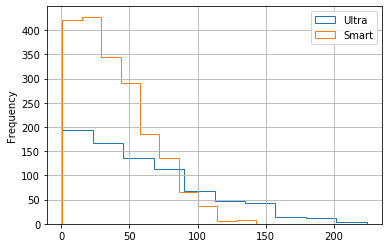

In [43]:
data_final.query('tariff == "ultra"')['messages'].plot(kind = 'hist', histtype = 'step', label = 'Ultra', grid = True, legend = True)

data_final.query('tariff == "smart"')['messages'].plot(kind = 'hist', histtype = 'step', label = 'Smart', grid = True, legend = True)


Пользователи тарифа smart в среднем отсылают меньше сообщений, нежели клиенты ultra, у которых еще и серезный разброс по занчениям 

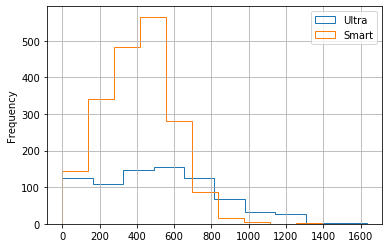

In [44]:
data_final.query('tariff == "ultra"')['call_duration'].plot(kind = 'hist', histtype = 'step', label = 'Ultra', grid = True, legend = True)
data_final.query('tariff == "smart"')['call_duration'].plot(kind = 'hist', histtype = 'step', label = 'Smart', grid = True, legend = True)


По звонкам ситуация интересная. Пользоватеди smart не очень отстают от ultra, но у пользователей больше разброс. Очевидно, что дорогим тарифом пользуются люди, которые изначально расччитывали на большое время разговора


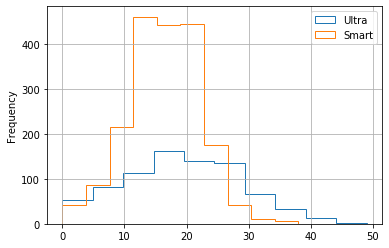

In [45]:
data_final.query('tariff == "ultra"')['gb_used'].plot(kind = 'hist', histtype = 'step', label = 'Ultra', grid = True, legend = True)
data_final.query('tariff == "smart"')['gb_used'].plot(kind = 'hist', histtype = 'step', label = 'Smart', grid = True, legend = True)



В среднем интернет трафик выше у пользователей ultra, но тут интересно то, что в ultra клиенты не часто вылезают за пределы пакета, в то время как клиенты smart делают это в большинстве случаев, переплачивая (иногда серьезно) за тариф. Но опять таки, у пользователей ultra сильнее разброс по данным

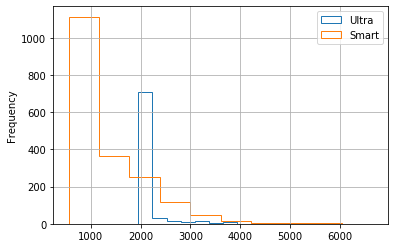

In [46]:
data_final.query('tariff == "ultra"')['revenue'].plot(kind = 'hist', histtype = 'step', label = 'Ultra', grid = True, legend = True)
data_final.query('tariff == "smart"')['revenue'].plot(kind = 'hist', histtype = 'step', label = 'Smart', grid = True, legend = True)


Такой разброс в smart результат активного использования дополнительных гб интернет трафика. У ultra же все занчения revenue сгруппированы в промежутке 1950 - 2100.

Не очень понимаю, что конкретно надо добавить

4) Проверим гипотезы

Примем за нулевую гипотезу, что прибыль с тарифов одинакова, альтернатива будет что они различаются. Сделаем это при помощи гипотезы о равенстве двух генеральных совокупностей, так как нам необходимо сравнить средний чек пользователй двух разных тарифов. Сделаем это с помощью t-критерия Стьюдента, т.к. ее часто применяют для проверки равентсва средних значений в двух выборках

In [47]:
u_revenue = data_final.query('tariff == "ultra"')['revenue']
s_revenue = data_final.query('tariff == "smart"')['revenue']
alpha = .05
results = st.ttest_ind(
    u_revenue, 
    s_revenue)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем гипотезу')
else:
    print('Все верно')

p-значение: 6.329111957845442e-134
Отвергаем гипотезу


p-значене слишком велико, поэтому отвергаем гипотезу о том, что прибыль от пользователей разных тарифов одинакова

Поставим нулевую гипотезу, что прибыль от пользователей в Москве похожа на прибыль от ползователей в остальных городах страны. Также применим тут гипотезу о равентсве двух генеральных совокупностей. Гипотеза о равенстве зависимых выборок тут не подойдет, так как используется для сравнения 'до' и 'после'. Сделаем это с помощью t-критерия Стьюдента, т.к. ее часто применяют для проверки равентсва средних значений в двух выборках

In [48]:
moscow = data_final.query('city == "Москва"')['revenue']
other = data_final.query('city != "Москва"')['revenue']
alpha = .05
results = st.ttest_ind(
    moscow, 
    other)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем гипотезу')
else:
    print('Все верно')

p-значение: 0.15132736242742234
Все верно


Гипотеза подтвердилась. p-value больше значения alpha, поэтому делать вывод о значимом различии между средней выручкой от москвичей и остальных жителей России нельзя


5) Из данных видно, что пользователи тарифа smart часто переплачивают за интернет, да и макисмальный чек от них выше: 6668 рублей против 4800 от от пользователей ultra. Общий разброс по прибыли у пользователей smart тоже больше, в то время как у клиентов ultra все более компактно: от 1950 до 2100. Разброс по прибыли подтверждается и медианной: медианная прибыль тарифа ultra - 1950 рублей(стоимость за месяц), у smart же медианная прибыль 978 рубля(месячная стоимость 550 рублей). Получается, что пользователи smart так или иначе каждый месяц переплачивают. Как мы видели, в большинстве случаев из-за мобильного интернета. Возможно при рекламной кампании стоит сделать упор на мобильный интернет и возможно попытаться перетянуть больше пользователей на тариф ultra. Или же изменить тариф smart. Например, поднять лимит интернета до 20 гб в месяц (среднее почти 17 гб), но и поднять стоимость тарифа(скажем, до 700 - 750 рублей).